# Example of upper limit computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import probfit
import iminuit
import math
from statnight.utils.wrappers import ModelWrapper, LossFunctionWrapper, MinuitWrapper
from statnight.parameters import Observable, Variable, Constant, POI, GaussianConstrained
from statnight.utils.stats import integrate1d
from statnight.hypothesis import Hypothesis
from statnight.hypotest import UpperLimit
from statnight.calculators import AsymptoticCalculator

## Scenario

Let's assume you want to find a resonnance between 0.1 and 3.0 GeV/c$^2$ of invariant mass of a system.

You have a signal region and a background only region:

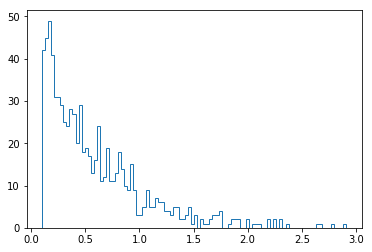

In [2]:
bounds = (0.1,3.0)

#background only
np.random.seed(10)
tau = 2.0
beta = 1./tau
data = np.random.exponential(beta, 1000)

data_bkg = data[(data > bounds[0]) & (data < bounds[1])]
plt.hist(data_bkg, bins=100, histtype='step');

In [3]:
#signal + background

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 4)
data = np.concatenate((data,peak))
data = data[(data > 0.1) & (data < 3)]

### Background fit, in background only region:

The background model is an exponential.

In [4]:
exp = probfit.Normalized(probfit.exponential, bounds)

model_bkg = ModelWrapper(exp)
model_bkg.add_obs(Observable("x", range = bounds))
tau = Variable("tau", range=(0.1, 5.0), initvalue=0.5,       initstep=0.05)
model_bkg.add_vars(tau)

LH_bkg = LossFunctionWrapper(probfit.UnbinnedLH(model_bkg, data_bkg))
minuit_bkg = MinuitWrapper(LH_bkg)

In [5]:
minuit_bkg.migrad();

FCN = 222.38871948523126 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 1.4889124356544732e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,tau,2.02224,0.0750417,,,0.1,5,No


In [6]:
tauval = minuit_bkg.values["tau"]
tauerr = minuit_bkg.errors["tau"]

### Signal + background fit in signal region:

The total model is a sum of a gaussian and an exponential. The tau parameter of the exponential will be constrained to the value obtained in the background only region.

In [7]:
bkg_pdf = model_bkg
sig_pdf = probfit.Normalized(probfit.gaussian, bounds)
bkg_pdf_ext = probfit.Extended(bkg_pdf, "Nbkg")
sig_pdf_ext = probfit.Extended(sig_pdf, "Nsig")
tot_pdf = probfit.AddPdf(bkg_pdf_ext, sig_pdf_ext)

#### Model definition:

Construct a model from a given probability density function (pdf) and then assign which parameters of the pdf are observables or variables/constants and initialize them.

Observable and Variable require a name and a range. Optional arguments can be given to Variable such as an initial value and initial step for minuit, and constraint wich is a function.
Constant only require a name and a value.

In [8]:
tot_model = ModelWrapper(tot_pdf)

tot_model.add_obs(Observable("x", range = bounds))

mean  = Constant("mean", value=1.2)
sigma = Constant("sigma", value= 0.1)
Nsig  = Variable("Nsig", range=(-10,len((data))), initvalue= 20.0, initstep=1.0)
tau   = GaussianConstrained("tau", mu=tauval, sigma=tauerr, range=(0.1, 5.0))
Nbkg  = Variable("Nbkg", range=(0,len((data))*1.1), initvalue= len(data), initstep=1.0)

tot_model.add_vars(mean, sigma, Nsig, tau, Nbkg)

tot_model.extended = True

In [9]:
LH_sb = LossFunctionWrapper(probfit.UnbinnedLH(tot_model, data, extended=True, extended_bound=bounds))

In [10]:
minuit_sb = MinuitWrapper(LH_sb, pedantic=True)

In [11]:
minuit_sb.migrad();

FCN = -1053.7145366647233 
 TOTAL NCALL = 62 
 NCALLS = 62 
 
 
 EDM = 8.237299626808698e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,tau,2.00097,0.0665918,,,0.1,5,No
1,Nbkg,250.627,16.4224,,,0,275,No
2,mean,1.2,1,,,,,Yes
3,sigma,0.1,1,,,,,Yes
4,Nsig,-0.597441,4.75289,,,-10,250,No


In [12]:
def plotfitresult(pdf, bounds, nbins, *args):
    x = np.linspace(bounds[0], bounds[1], nbins)
    bin_centers = x[:-1] + np.diff(x)/2.
    y = np.zeros(bin_centers.shape)
    
    for i in range(nbins-1):
        y[i] = integrate1d(pdf, (x[i],x[i+1]), 100, *args)
        
    plt.plot(bin_centers, y, "-r")     

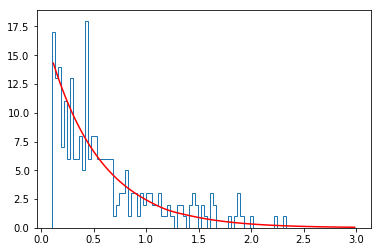

In [13]:
nbins = 100
fit_result = minuit_sb.values.values()
plt.hist(data, bins=nbins, histtype='step', range=bounds);
plotfitresult(tot_model, bounds, nbins, *fit_result)

## Upper limit:

In [14]:
null_hypothesis = Hypothesis(LH_sb, POI("Nsig"))
alt_hypothesis = Hypothesis(LH_sb, POI("Nsig", 0.))

In [15]:
calc = AsymptoticCalculator()

In [16]:
ul_test = UpperLimit(null_hypothesis, alt_hypothesis, calc, CLs=True)

In [17]:
ul_test.bestfitpoi = POI("Nsig", minuit_sb.values["Nsig"])
ul_test.scanvalues = np.linspace(0.1, 12, 60)

In [18]:
ul_test.upperlimit();

Get fit best values for nuisance parameters for the alternative hypothesis!


FCN = -1056.5388382521423 
 TOTAL NCALL = 30 
 NCALLS = 30 
 
 
 EDM = 5.406210869109502e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,tau,1.98414,0.0665648,,,0.1,5,No
1,Nbkg,252.88,15.8731,,,0,275,No
2,mean,1.2,1,,,,,Yes
3,sigma,0.1,1,,,,,Yes
4,Nsig,0,1,,,,,Yes


Observed upper limit: Nsig = 10.418050310358991
Expected upper limit: Nsig = 10.741127045645264
Expected upper limit +1 sigma: Nsig = 14.945702550856621
Expected upper limit -1 sigma: Nsig = 7.738107083864896
Expected upper limit +2 sigma: Nsig = 20.035772474446905
Expected upper limit -2 sigma: Nsig = 5.763945040600495


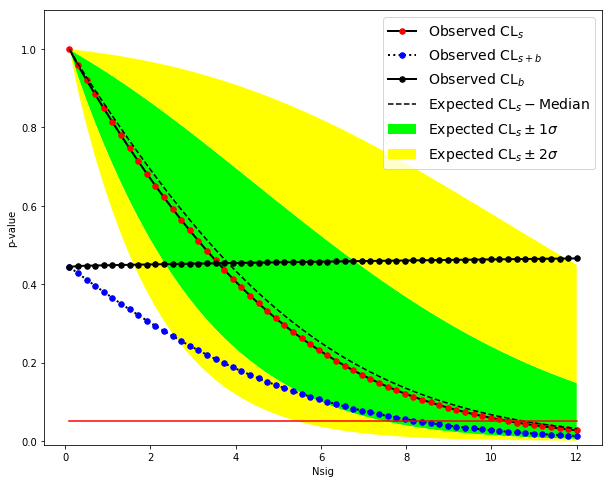

In [19]:
ul_test.plot()